# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #8
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 31st, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Application of Data Augmentation

A plant nursery in Cambridge is exprimentally cross-breeding two types of hibiscus flowers: blue and pink. The goal is to create an exotic flower whose petals are pink with a ring of blue on each. 

There are four types of child plant that can result from this cross-breeding: 

  - Type 1: blue petals
  - Type 2: pink petals 
  - Type 3: purple petals
  - Type 4: pink petals with a blue ring on each (the desired effect). 

Out of 197 initial cross-breedings, the nursery obtained the following distribution over the four types of child plants: 
$$Y = (y_1, y_2, y_3, y_4) = (125, 18, 20, 34)$$
where $y_i$ represents the number of child plants that are of type $i$.

The nursery then consulted a famed Harvard plant geneticist, who informed them that the probability of obtaining each type of child plant in any single breeding experiment is as follows:
$$ \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4}.$$
Unfortunately, the geneticist did not specify the quantity $\theta$.

Clearly, the nursery is interested in understanding how many cross-breeding they must perform, on average, in order to obtain a certain number of child plants with the exotic blue rings. To do this they must be able to compute $\theta$. 

The owners of the nursery, being top students in AM207, decided to model the experiment in hopes of discovering $\theta$ using the results from their 197 initial experiments. 

They chose to model the observed data using a multinomial model and thus calculated the likelihood to be:
$$ p(y  \vert  \theta) \propto (2+\theta)^{y_1} (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$

Being good Bayesians, they also imposed a prior on $\theta$, $\rm{Beta}(a, b)$.

Thus, the posterior is:
$$ p(\theta \vert  Y) \propto \left( 2+\theta \right)^{y_1} (1-\theta)^{y_2+y_3} \, \theta^{
y_4} \, \theta^{a-1} \, (1-\theta)^{b-1}. $$

If the nursery owners are able to sample from the posterior, they would be understand the distribution of $\theta$ and make appropriate estimates.

### Part A: Sampling using data augmentation

Realizing that it would be difficult to sample from the posterior directly and after being repeatedly frustrated by attempts of Metropolis-Hastings and Gibbs sampling for this model, the nursery owners decided to augment their model and hopefully obtain a friendlier looking distribution that allows for easy sampling.

They augment the data with a new variable $z$ such that:
$$z + (y_1 - z) = y_1.$$
That is, using $z$, we are breaking $y_1$, the number of type I child plants, into two subtypes. Let the probability of obtain the two subtype be $1/2$ and $\theta/4$, respectively. Now, we can interpret $y_1$ to be the total number of trials in a binomial trial. Thus, the new likelihood can be written as
$$ p(y, z  \vert  \theta) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$




# P1A (1) - Derive the joint posterior $p(\theta, z  \vert  y)$

$$ p(\theta, z \vert y) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z} (1-\theta)^{y_2+y_3} \, \theta^{y_4} \theta^{a-1} \, (1-\theta)^{b-1} $$

Grouping the $\theta$ terms together and simplifying:

$$ p(\theta, z \vert y) \propto \binom{y_{1}}{z} \left (\frac{1}{4} \right )^{\alpha+y_4} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z+\alpha + y_4} (1-\theta)^{y_2+y_3+b-1}$$

Next we derive the conditional distributions for Gibbs Sampling:

$$ p(\theta \vert z, y) \propto \left(\frac{1}{4} \right )^{z+\alpha + y_4} \theta^{z+\alpha + y_4} (1-\theta)^{y_2+y_3+b-1}$$

Next we look at only the terms from the joint posterior that contain z to derive the conditionals for z:

$$ p(z \vert y,\theta) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z+\alpha + y_4}$$

Because we know that the probabilities $\left (\frac{1}{2} \right)$ and $\left(\frac{\theta}{4}\right)$ need to add up to 1, we can divide both by $\left (\frac{1}{2} \right) + \left(\frac{\theta}{4} \right)$ and obtain the following:

$$ p(z \vert y,\theta) \propto \binom{y_{1}}{z} \left (\frac{2}{2 +\theta} \right )^{y_1-z} \left(\frac{\theta}{2+ \theta} \right )^{z}$$

Now we have a binomial distribution with $N=y_1$ and $p=\left (\frac{\theta}{2 +\theta} \right )$

# P1A (1) - sample from it using Gibbs sampling -

I began by looking at the priors given in the prompt, and that 34 of the 197 offsprings were type 4.  In addition to reviewing lecture notes I also looked to http://stats.stackexchange.com/questions/47771/what-is-the-intuition-behind-beta-distribution for insights on beta distributions to set the parameters that expressed the prior.  

For the parameters I chose a = 17 and b= 83.  Given (a/(a+b)), I calculated 17% as the estimated probability of obtaining a type 4 plant.

In [1]:
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('classic')

# the params. for the beta distribution
a = 17
b = 83

# use 100,000 iterations
N=100000

thetaTotals=np.zeros(N)
z=np.zeros(N)

thetaTotals[0] = 0.15
z[0] = 5
y = [125,18,20,34]

for i in np.arange(1,N):
    alpha= a+z[i-1]+y[3]
    beta = b+y[1] + y[2]
    thetaTotals[i] = stats.gamma.rvs(alpha, scale=1.0/beta)
    z[i] = stats.binom.rvs(n=y[0], p=(thetaTotals[i]/(2+ thetaTotals[i])))

# P1A (2) - Visualize the distribution of theta and, from this distribution, estimate the probability of obtaining a type 4 child plant (with the blue rings) in any cross-breeding experiment.

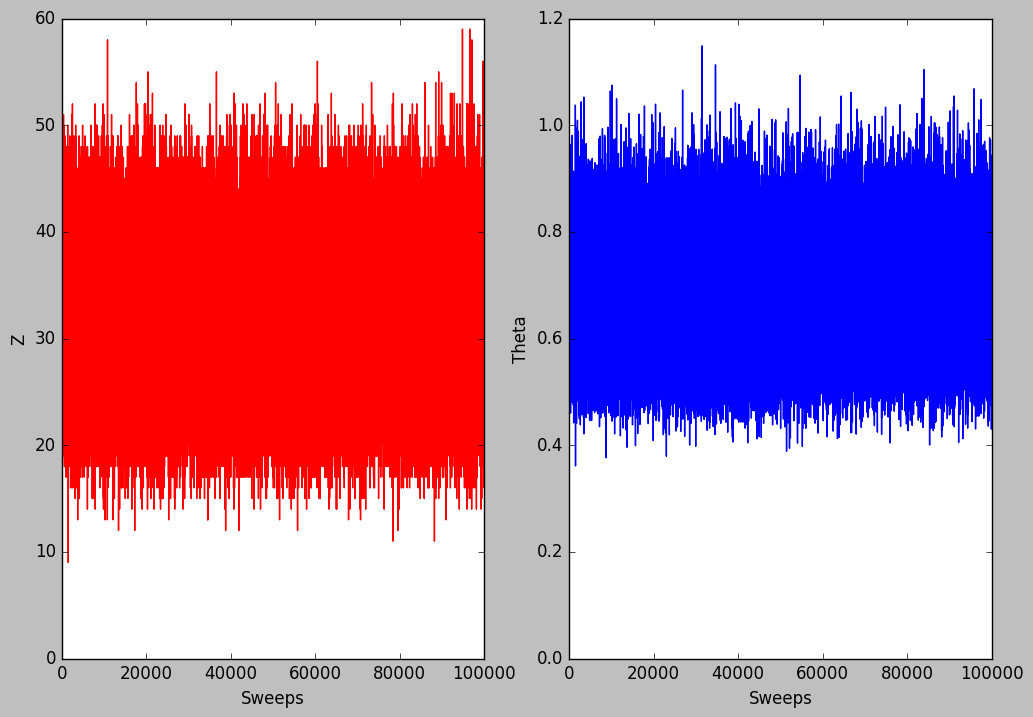

In [2]:
plt.figure(figsize=[12,8])
plt.subplot(121)
plt.plot(z, linewidth=1, c='r')
plt.ylabel('Z')
plt.xlabel('Sweeps')
plt.subplot(122)
plt.plot(thetaTotals, linewidth=1, c='b')
plt.ylabel('Theta')
plt.xlabel('Sweeps')

# First, I will use a burnin and do thinning on the samples -

In [3]:
thin=10
burnin=1000
ztrace=z[burnin+1:N:thin]
thetaTrace=thetaTotals[burnin+1:N:thin]

# Next, I examine the correlation plots to make sure that there is not an issue with autocorrelation after the burnin and thinning process was conducted -

In [4]:
def corrplot(trace, maxlags=50):
    plt.figure(figsize=[6,4])
    plt.acorr(trace-np.mean(trace), normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

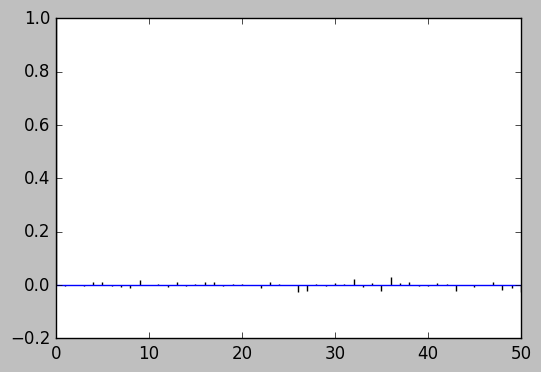

In [5]:
corrplot(ztrace)

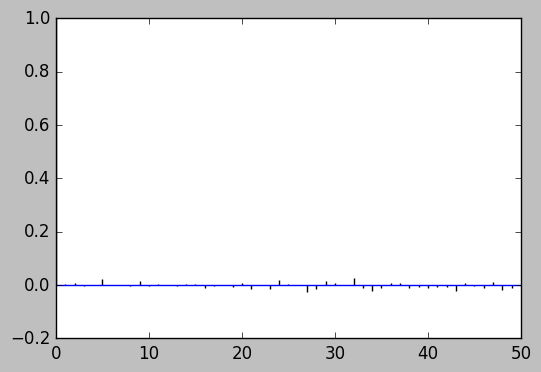

In [6]:
corrplot(thetaTrace)

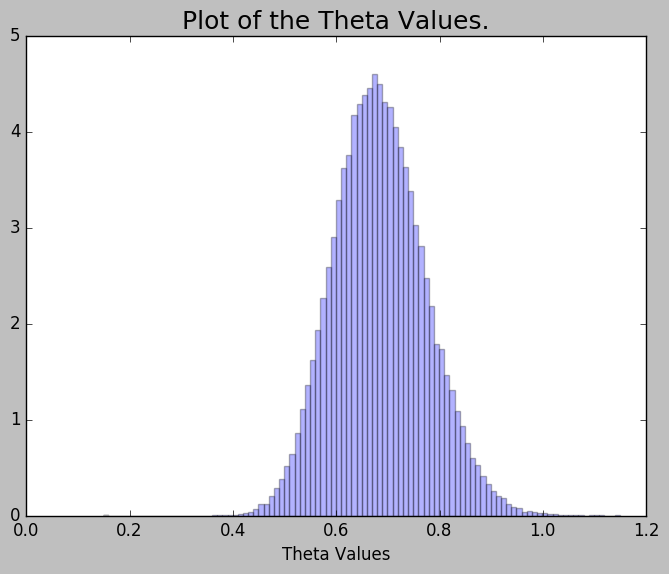

In [7]:
plt.hist(thetaTotals, bins=100, alpha=0.3, normed=True)
plt.title("Plot of the Theta Values.", fontsize='18')
plt.xlabel('Theta Values')

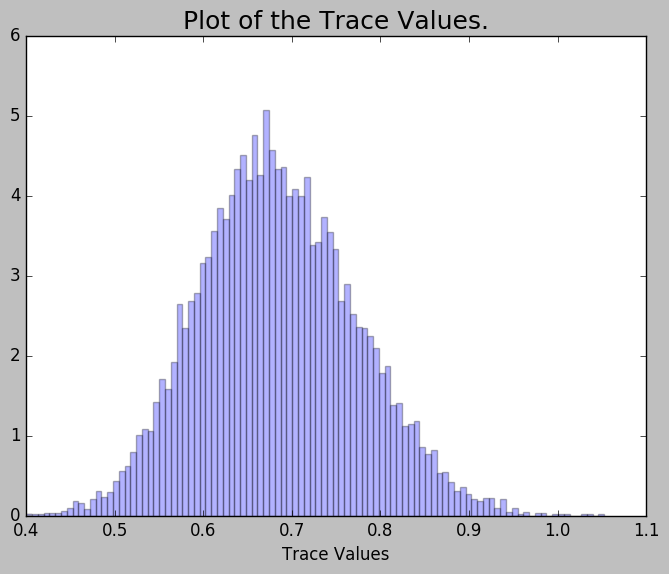

In [8]:
plt.hist(thetaTrace, bins=100, alpha=0.3, normed=True)
plt.title("Plot of the Trace Values.", fontsize='18')
plt.xlabel('Trace Values')

# estimate the probability of obtaining a type 4 child plant (with the blue rings) in any cross-breeding experiment.

In [9]:
finalTheta = np.mean(thetaTrace)

# get the estimated prob. of obtaining a type 4 plant
finalAnswer = finalTheta/4

print (finalAnswer)

0.171030358119


The probability estimation of obtaining a type 4 child plant (with the blue rings) is 0.171030358119